# **1. Install packages**

In [2]:
%%capture
# !pip install catboost

# **2. Load libraries**

In [4]:
# Data manipulation
#=================================================
import pandas as pd
import numpy as np

# Data visualization
#=================================================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Data preprocessing
#==============================================================
import spacy
import re
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Models
#==========================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier


# Metrics
#============================================================================
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

# tqdm
#===============================================================
from tqdm.auto import tqdm

# warnings
#=====================================
import warnings
warnings.filterwarnings('ignore')

In [5]:
# !pip install --upgrade pandas "dask[complete]"

In [6]:
# !pip install lightgbm
# !pip install catboost 
# !pip install xgboost 

# **3. Load data**

In [8]:
data = pd.read_csv("mental_health.csv")
data.head()

,text,label
0,I recently went through a breakup and she said...,depression
1,"I do not know how to navigate these feelings, ...",depression
2,"So I have been with my bf for 5 months , and h...",depression
3,I am so exhausted of this. Just when I think I...,SuicideWatch
4,I have been severly bullied since i was 5 till...,depression


- **Data set size**

In [10]:
rows, cols = data.shape[0], data.shape[1]

print(f'Rows: {rows}')
print(f'Columns: {cols}')

Rows: 20364
Columns: 2


- **Data set information**

In [12]:
print("##" * 30)
print(" " * 17, "Data set Information")
print("##" * 30)
print(data.info())

############################################################
                  Data set Information
############################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20364 entries, 0 to 20363
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20364 non-null  object
 1   label   20364 non-null  object
dtypes: object(2)
memory usage: 318.3+ KB
None


# **4. EDA**

- **Duplicate rows**

In [15]:
print(data.duplicated().sum())

15


In [16]:
data = data.drop_duplicates(ignore_index = True)

print(data.duplicated().sum())

0


- **Missing values**

In [18]:
df_null_values = data.isnull().sum().to_frame().rename(columns = {0:'count'})
df_null_values['%'] = (df_null_values['count'] / len(data)) * 100
df_null_values

,count,%
text,0,0.0
label,0,0.0


In [19]:
data = data[:1000]

In [20]:
print(len(data))

1000


- **WordCloud**

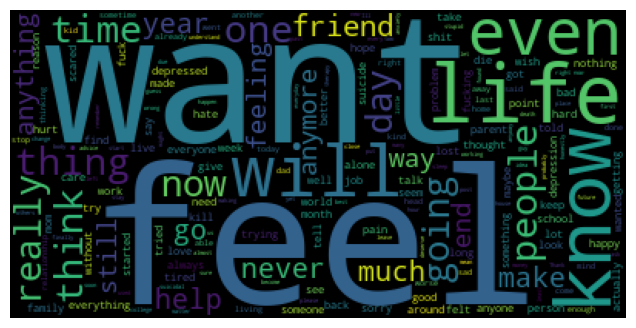

In [22]:
all_text = " ".join(data['text'])
wc = WordCloud(stopwords = STOPWORDS).generate(all_text)

plt.figure(figsize = (9,4))
plt.imshow(wc)
plt.axis('off')
plt.show()

- **Text length**

--------------------------
Max lenght: 2153
--------------------------


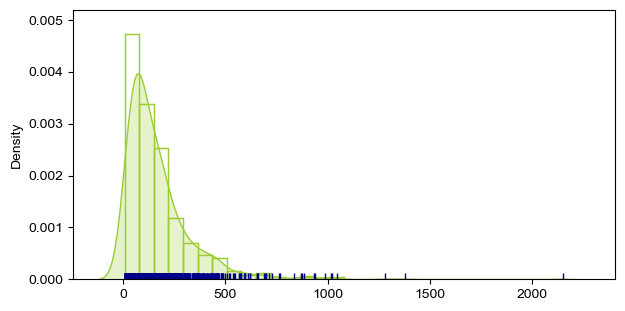

In [24]:
length_seq = [len(txt.split()) for txt in data['text']]
print("--------------------------")
print(f'Max lenght: {max(length_seq)}')
print("--------------------------")

fig,ax = plt.subplots(figsize = (7,3.5))
sns.set_style('darkgrid')
sns.kdeplot(length_seq, fill = True, color = 'yellowgreen', ax = ax)
sns.histplot(length_seq, stat = 'density', bins = 30, fill = False, color = 'yellowgreen', ax = ax)
sns.rugplot(length_seq, color = 'darkblue', ax = ax)
fig.show()

- **Distribution of labels**

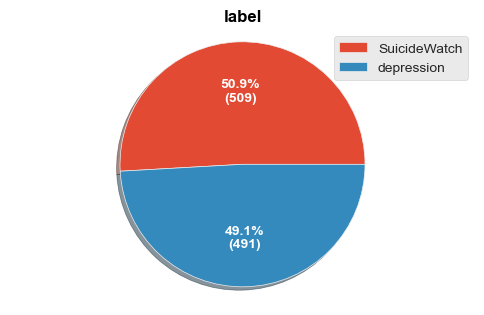

In [26]:
plt.style.use('ggplot')

def autopct_fun(abs_values):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.1f}%\n({next(gen)})"

fig,ax = plt.subplots(figsize = (6,3.5))
df_class = data['label'].value_counts().to_frame()
labels = df_class.index
values = df_class.iloc[:,0].to_list()
ax.pie(x = values, labels = labels, autopct = autopct_fun(values), shadow = True, textprops = {'color':'white', 'fontsize':10, 'fontweight':'bold'})
ax.legend(labels, loc = 'best')
ax.set_title('label', fontsize = 12, fontweight = "bold", color = "black")
ax.axis('equal')

fig.show()

**We see that the classes are balanced.**

# **5. Preprocessing**

- **Text preprocessing**

In [30]:
nlp = spacy.load("en_core_web_sm")

In [31]:
def preprocess_text(txt:str):
    
    txt = re.sub('[^a-zA-Z]', ' ', txt)
    txt = txt.lower()
    txt = " ".join(txt.split())
    
    doc = nlp(txt)
    
    tokens_filtered = []
    
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
            
        tokens_filtered.append(token.lemma_)
        
    return " ".join(tokens_filtered)

In [32]:
data['text_prep'] = data['text'].apply(preprocess_text)

In [33]:
data.head()

,text,label,text_prep
0,I recently went through a breakup and she said...,depression,recently go breakup say want friend say try ta...
1,"I do not know how to navigate these feelings, ...",depression,know navigate feeling new feeling stretch unde...
2,"So I have been with my bf for 5 months , and h...",depression,bf month tell depressed week particular happen...
3,I am so exhausted of this. Just when I think I...,SuicideWatch,exhausted think finally rest think maybe thing...
4,I have been severly bullied since i was 5 till...,depression,severly bully till result depressed misanthrop...


In [34]:
LABELS = data['label'].unique()
LABELS

array(['depression', 'SuicideWatch'], dtype=object)

In [35]:
label2id = dict(zip(LABELS, np.arange(len(LABELS), dtype = np.float32)))
label2id

{'depression': 0.0, 'SuicideWatch': 1.0}

In [36]:
data['label_prep'] = data['label'].map(label2id)

- **Text length after preprocessing**

########################################
Max lenght: 729
########################################


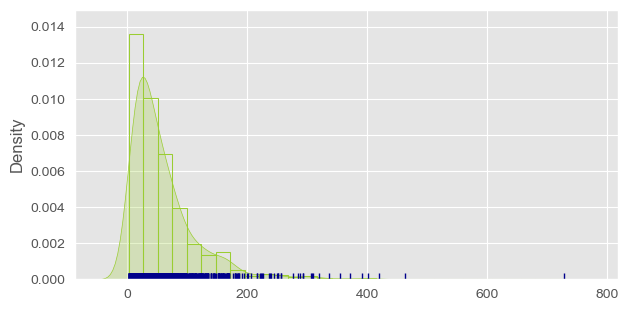

In [38]:
length_seq_after = [len(txt.split()) for txt in data['text_prep']]

print("##" * 20)
print(f'Max lenght: {max(length_seq_after)}')
print("##" * 20)

fig,ax = plt.subplots(figsize = (7,3.5))
sns.set_style('darkgrid')
sns.kdeplot(length_seq_after, fill = True, color = 'yellowgreen', ax = ax)
sns.histplot(length_seq_after, stat = 'density', bins = 30, fill = False, color = 'yellowgreen', ax = ax)
sns.rugplot(length_seq_after, color = 'darkblue', ax = ax)
fig.show()

**`Split the data set into:`**
- **train = 70%**
- **test = 30%**

In [40]:
X = data['text_prep']
y = data['label_prep']

SEED = 1234

X_train, X_test, y_train, y_test = tts(X,
                                       y, 
                                       test_size = 0.3, 
                                       random_state = SEED)

In [41]:
y_train.value_counts()

label_prep
1.0    355
0.0    345
Name: count, dtype: int64

In [42]:
y_test.value_counts()

label_prep
1.0    154
0.0    146
Name: count, dtype: int64

- **TfidfVectorizer**

In [44]:
vectorizer = TfidfVectorizer()
train_vectorizer = vectorizer.fit_transform(X_train)
test_vectorizer = vectorizer.transform(X_test)

train_vectorizer = train_vectorizer.toarray()
test_vectorizer = test_vectorizer.toarray()

# **6. Models**

In [46]:
# We define the candidate models.
lr = LogisticRegression(random_state = SEED, n_jobs = -1)
rf = RandomForestClassifier(random_state = SEED, n_jobs = -1)
et = ExtraTreesClassifier(bootstrap = True, n_jobs = -1, random_state = SEED)
xgb = XGBClassifier(random_state = SEED, n_jobs = -1)
lgbm = LGBMClassifier(random_state = SEED, n_jobs = -1)
cb = CatBoostClassifier(random_state = SEED, verbose = 0)

MODELS = [lr, rf, et, xgb, lgbm, cb]

In [47]:
# Training!!!

accuracy_train = {}
accuracy_test = {}

for model in tqdm(MODELS):
    name = type(model).__name__
    model.fit(train_vectorizer, y_train)
    y_pred_train = model.predict(train_vectorizer)
    accuracy_train[name] = accuracy_score(y_train, y_pred_train)
    y_pred_test = model.predict(test_vectorizer)
    accuracy_test[name] = accuracy_score(y_test, y_pred_test)
    print(f'* {name} finished')

  0%|          | 0/6 [00:00<?, ?it/s]

* LogisticRegression finished
* RandomForestClassifier finished
* ExtraTreesClassifier finished
* XGBClassifier finished
[LightGBM] [Info] Number of positive: 355, number of negative: 345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6983
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 336
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507143 -> initscore=0.028573
[LightGBM] [Info] Start training from score 0.028573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

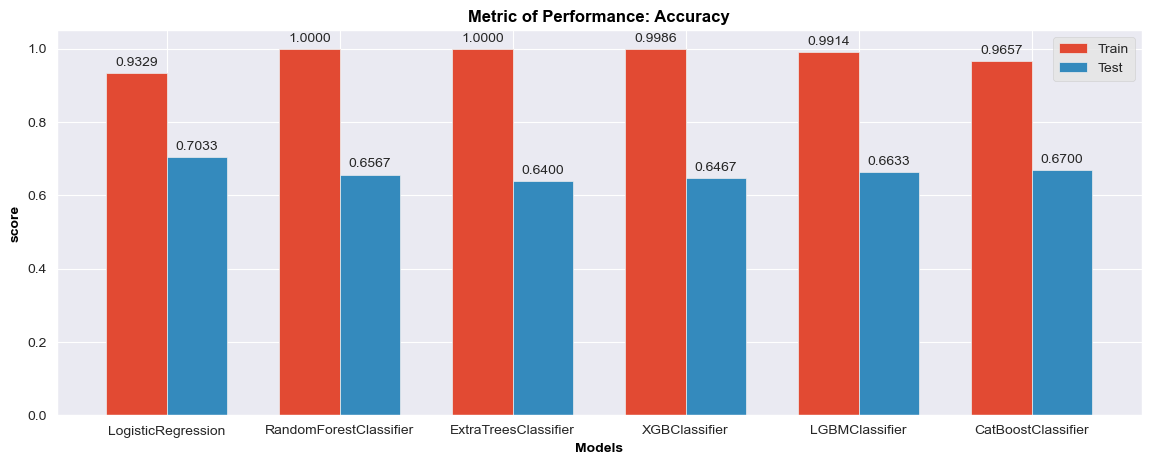

In [48]:
metric_train = pd.DataFrame.from_dict(accuracy_train, orient = 'index')
metric_train = metric_train.rename(columns = {0:'Train'})

metric_test = pd.DataFrame.from_dict(accuracy_test, orient = 'index')
metric_test = metric_test.rename(columns = {0:'Test'})

fig,ax = plt.subplots(figsize = (14,5))
plt.style.use('ggplot')

labels = metric_train.index.to_list()
values_train = metric_train.iloc[:,0].to_list()
values_test = metric_test.iloc[:,0].to_list()
x = np.arange(len(labels))
width = 0.35

rects1 = ax.bar(x = x - width/2, height = values_train, width = width, label = 'Train')
rects2 = ax.bar(x = x + width/2, height = values_test, width = width, label = 'Test')


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(text = f'{height:.4f}', 
                    xy = (rect.get_x() + rect.get_width()/2, height), 
                    xytext = (0,3), 
                    textcoords = "offset points", 
                    ha = "center", 
                    va = "bottom")
        
autolabel(rects1)
autolabel(rects2)
ax.set_title("Metric of Performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
ax.set_ylabel("score", fontsize = 10, fontweight = "bold", color = "black")
ax.set_xlabel("Models", fontsize = 10, fontweight = "bold", color = "black")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.show()

The best model among all the candidates is **CatBoostClassifier**, so we will calculate some additional metrics based on this model.

# **7. Metrics**

In [51]:
# Predictions!!!

y_pred_train = cb.predict(train_vectorizer)
y_pred_test = cb.predict(test_vectorizer)

y_pred_prob_train = cb.predict_proba(train_vectorizer)[:,1]

y_pred_prob_test = cb.predict_proba(test_vectorizer)[:,1]

- **Classification Report**

In [53]:
print("##" * 30)
print(" " * 13, "Classification Report Train")
print("##" * 30)
print(classification_report(y_train, y_pred_train, target_names = LABELS))
print("")
print("##" * 30)
print(" " * 13, "Classification Report Test")
print("##" * 30)
print(classification_report(y_test, y_pred_test, target_names = LABELS))

############################################################
              Classification Report Train
############################################################
              precision    recall  f1-score   support

  depression       0.98      0.95      0.96       345
SuicideWatch       0.95      0.98      0.97       355

    accuracy                           0.97       700
   macro avg       0.97      0.97      0.97       700
weighted avg       0.97      0.97      0.97       700


############################################################
              Classification Report Test
############################################################
              precision    recall  f1-score   support

  depression       0.67      0.64      0.65       146
SuicideWatch       0.67      0.70      0.69       154

    accuracy                           0.67       300
   macro avg       0.67      0.67      0.67       300
weighted avg       0.67      0.67      0.67       300



- **Confusion Matrix**

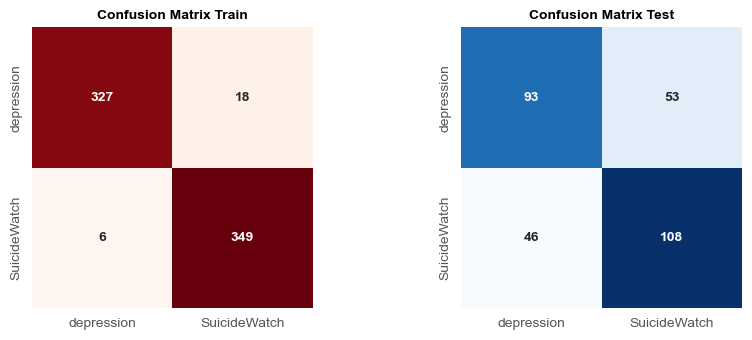

In [55]:
cf_mx_train = confusion_matrix(y_train, y_pred_train)
cf_mx_test = confusion_matrix(y_test, y_pred_test)

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9,3.5))

sns.heatmap(cf_mx_train, cmap = 'Reds', 
            fmt = '', annot = True, cbar = False, 
            annot_kws = {'fontsize':10, 'fontweight':'bold'},
            square = True, xticklabels = LABELS, yticklabels = LABELS, ax = ax[0])

sns.heatmap(cf_mx_test, cmap = 'Blues', 
            fmt = '', annot = True, cbar = False, 
            annot_kws = {'fontsize':10, 'fontweight':'bold'},
            square = True, xticklabels = LABELS, yticklabels = LABELS, ax = ax[1])

ax[0].set_title("Confusion Matrix Train", fontsize = 10, fontweight = "bold", color = "black")
ax[1].set_title("Confusion Matrix Test", fontsize = 10, fontweight = "bold", color = "black")
fig.tight_layout()
fig.show()

- **ROC curve**

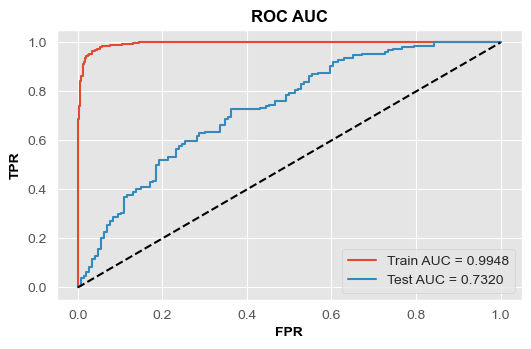

In [57]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_test)

auc_train = roc_auc_score(y_train, y_pred_prob_train)
auc_test = roc_auc_score(y_test, y_pred_prob_test)

fig,ax = plt.subplots(figsize = (6,3.5))
ax.plot(fpr_train, tpr_train, label = f'Train AUC = {auc_train:.4f}')
ax.plot(fpr_test, tpr_test, label = f'Test AUC = {auc_test:.4f}')
ax.plot([0,1], linestyle = '--', color = 'black')
ax.set_xlabel("FPR", fontsize = 10, fontweight = 'bold', color = 'black')
ax.set_ylabel("TPR", fontsize = 10, fontweight = 'bold', color = 'black')
ax.legend()
ax.set_title("ROC AUC", fontsize = 12, fontweight = "bold", color = "black")
fig.show()

- **Precision Recall curve**

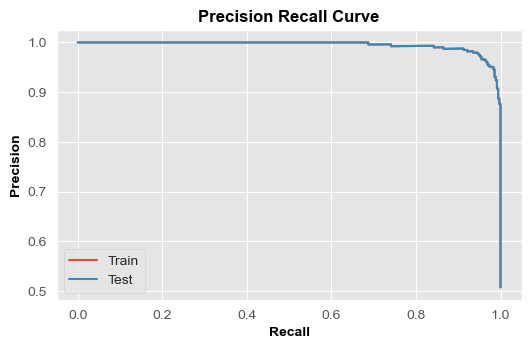

In [59]:
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_prob_train, )
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_prob_test)

fig,ax = plt.subplots(figsize = (6,3.5))
ax.plot(recall_train, precision_train, label = 'Train')
ax.plot(recall_train, precision_train, label = 'Test')
ax.set_xlabel("Recall", fontsize = 10, fontweight = 'bold', color = 'black')
ax.set_ylabel("Precision", fontsize = 10, fontweight = 'bold', color = 'black')
ax.legend()
ax.set_title("Precision Recall Curve", fontsize = 12, fontweight = "bold", color = "black")
fig.show()